##Created by Daisy Contreras Martinez, 2024 OCIO Data Science Lab Intern.
Mentored by Dr. Alex White.


# SCI Animals (Camera Traps) Classification
Goal: Drawing from past generations of Data Science Lab Interns, I aim to improve the current image
classification model in terms of loss and accuracy by starting fresh for the purpose of
estimating the current population density and habitat distribution of the island-spotted skunk
on SCI since due to its small population and limited distribution, the island-spotted skunk is
listed as a subspecies of special concern by the State of California, making it one of the
world's rarest carnivores.

Moreover, on another note, in contributing to this focus of machine learning
and fulfilling my role as an intern, this end-product of the model will help in the conservation
and management of the island's ecosystem, as understanding the skunk population changing dynamics helps develop effective conservation strategies and mitigate the impact of
predators.

Note: Will use this model to process approximately 1 million
camera trap images that have been collected since 2017
with the UCSB-Smithsonian Scholar Camera Traps on
Santa Cruz Island.

Note: This model is classifying: Birds, Empty (Species Frames), Foxes, and Skunks in which the skunk crew deploy camera traps throughout Santa Cruz Island for the purpose of classifying these images (data).

## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our image classification end-goal model.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [ ]:
# Import the os module for interacting with the operating system
# - This module provides functions to work with file and directory paths, environment variables, and other OS-related tasks.
# - Google Colab Runtime type: Python 3.

import os

# Import the layers module from TensorFlow Keras
# - This module provides various types of layers used to build neural network models.
# - Layers are the building blocks of a neural network, such as Dense, Conv2D, and MaxPooling2D.

from tensorflow.keras import layers

# Import the Model class from TensorFlow Keras
# - The Model class is used to define and create neural network models.
# - It allows for flexible model building by connecting input and output layers and configuring model architectures.

from tensorflow.keras import Model

Now let's download the weights:

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-08-26 21:46:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.5MB/s    in 4.9s    

2024-08-26 21:46:52 (17.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the InceptionV3 model, which is a type of deep learning model used for analyzing images.

from tensorflow.keras.applications.inception_v3 import InceptionV3

# This line sets up the path to a file that contains "pre-trained weights," which are like the model's memory
# from learning on a large set of images, like ImageNet.

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create an instance of the InceptionV3 model with some specific settings:
# - input_shape=(150, 150, 3): This means the model expects input images that are 150x150 pixels in size and have 3 color channels
# (like an RGB photo).
# - include_top=False: This means the model won't include the final layers usually used for classifying images.
# - weights=None: We're not loading any weights into the model yet (we'll do this in the next step).

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)

# Load the pre-trained weights from the file into the model.
# These weights help the model recognize patterns in images based on what it learned before.

pre_trained_model.load_weights(local_weights_file)

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [ ]:
# Loop through each layer in the pre-trained model.
for layer in pre_trained_model.layers:
    # Set the layer to be non-trainable, meaning its weights won't be updated during training.
    layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [ ]:
# Get the 'mixed7' layer from the pre-trained model. This is one of the layers deep within the model where more complex patterns
# are recognized.

last_layer = pre_trained_model.get_layer('mixed7')

# Print the shape (dimensions) of the output (like checking the size of the data) that comes from this 'mixed7' layer. This helps
# us understand what the layer is producing.

print('last layer output shape:', last_layer.output.shape)

# Store the output of the 'mixed7' layer in a variable called last_output. I might use this output later for further processing or
# adding new layers.

last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Now let's stick a fully connected classifier on top of `last_output`:

In [ ]:
# Import necessary modules: layers for building the model and RMSprop optimizer for training.

from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

# Flatten the output of the last layer to a single dimension.
# Conceptual meaning: Flattening converts the complex multi-dimensional output from the previous layers
# into a simple one-dimensional array, making it easier for the next layer to process the data.

x = layers.Flatten()(last_output)

# Add a fully connected (Dense) layer with 1,024 neurons and ReLU activation.
# Conceptual meaning: This dense layer acts as a high-level feature detector.
# It combines all the features learned so far and starts making sense of the patterns.
# The ReLU activation function helps the model focus on the most important features by zeroing out negative values.

x = layers.Dense(1024, activation='relu')(x)

# Add a dropout layer to help prevent overfitting by randomly setting 20% of the neurons to zero during training.
# Conceptual meaning: Dropout helps the model become more robust by preventing it from relying too much on any one feature.
# This makes the model better at generalizing to new data.

x = layers.Dropout(0.2)(x)

# Add a final Dense layer with 4 units (one for each category) and softmax activation.
# Conceptual meaning: This layer is the decision-making layer. It assigns probabilities to each of the 4 classes
# (e.g., fox, skunk, bird, empty) based on the patterns detected in the image. Softmax ensures these probabilities sum to 1,
# allowing the model to make a final classification.

x = layers.Dense(4, activation='softmax')(x)

# Create the final model that takes the input of the pre-trained model and gives the output `x`.
# Conceptual meaning: The entire model is now ready to take an input image, process it through the various layers
# (including both pre-trained and newly added ones), and output a prediction about which of the 4 classes the image belongs to.

model = Model(pre_trained_model.input, x)

# Compile the model, setting up the loss function, optimizer, and metrics for training.
# Conceptual meaning: Compiling the model finalizes the setup, specifying how the model will learn (optimizer),
# how mistakes will be measured (loss function), and what performance metric (accuracy) we care about during training.

model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for multi-class classification with integer labels.
    optimizer=RMSprop(learning_rate=0.0001), # RMSprop optimizer is used with a small learning rate to update the model's weights.
    metrics=['accuracy']  # Track accuracy during training to monitor the model's performance.
)


#Importing Google Drive ZIPPED Dataset

In [ ]:
from pathlib import Path
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/sci.zip"

Archive:  /content/drive/MyDrive/sci.zip
   creating: sci/train/
   creating: sci/train/bird/
  inflating: sci/train/bird/217 (2).jpg  
  inflating: sci/train/bird/217.jpg  
  inflating: sci/train/bird/218 (2).jpg  
  inflating: sci/train/bird/218.jpg  
  inflating: sci/train/bird/219 (2).jpg  
  inflating: sci/train/bird/219.jpg  
  inflating: sci/train/bird/220 (2).jpg  
  inflating: sci/train/bird/220.jpg  
  inflating: sci/train/bird/221 (2).jpg  
  inflating: sci/train/bird/221.jpg  
  inflating: sci/train/bird/228.jpg  
  inflating: sci/train/bird/229.jpg  
  inflating: sci/train/bird/230 (2).jpg  
  inflating: sci/train/bird/230.jpg  
  inflating: sci/train/bird/231.jpg  
  inflating: sci/train/bird/234.jpg  
  inflating: sci/train/bird/235.jpg  
  inflating: sci/train/bird/236 (2).jpg  
  inflating: sci/train/bird/236.jpg  
  inflating: sci/train/bird/237.jpg  
  inflating: sci/train/bird/238 (2).jpg  
  inflating: sci/train/bird/238.jpg  
  inflating: sci/train/bird/239 (2).jp

In [ ]:
# Import necessary libraries

import os  # Provides functions to interact with the operating system, like file paths.
import zipfile  # Allows handling of ZIP files, though not directly used in this code snippet.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Used for generating batches of image data with real-time
                                                                    # data augmentation.

# Define the base directory for the dataset
# This is the main folder where your image data is stored.

base_dir = '/content/sci'

# Define directories for training and validation datasets
# These folders will contain the images for training and testing the model.

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Define subdirectories for each class within the training and validation datasets
# These are specific folders for each category of images (bird, empty, fox, skunk).

train_bird_dir = os.path.join(train_dir, 'bird')
train_empty_dir = os.path.join(train_dir, 'empty')
train_fox_dir = os.path.join(train_dir, 'fox')
train_skunk_dir = os.path.join(train_dir, 'skunk')

validation_bird_dir = os.path.join(validation_dir, 'bird')
validation_empty_dir = os.path.join(validation_dir, 'empty')
validation_fox_dir = os.path.join(validation_dir, 'fox')
validation_skunk_dir = os.path.join(validation_dir, 'skunk')

# Optionally, list filenames in each training subdirectory
# This is useful for debugging, to check if the files are correctly organized.

train_bird_fnames = os.listdir(train_bird_dir)
train_empty_fnames = os.listdir(train_empty_dir)
train_fox_fnames = os.listdir(train_fox_dir)
train_skunk_fnames = os.listdir(train_skunk_dir)

# Set up data augmentation for the training dataset
# Data augmentation is a technique to artificially expand the size of a training dataset by creating modified versions of images.
# - rescale=1./255: Normalizes the pixel values to a range between 0 and 1.
# - rotation_range=40: Randomly rotates the image up to 40 degrees.
# - width_shift_range=0.2 and height_shift_range=0.2: Randomly shifts the image horizontally or vertically by up to 20% of the
# image width or height.
# - shear_range=0.2: Applies a shear transformation (like slanting).
# - zoom_range=0.2: Randomly zooms into the image by up to 20%.
# - horizontal_flip=True: Randomly flips the image horizontally.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Set up rescaling for the validation dataset (no augmentation)
# For the validation set, we typically don't want to alter the images, just rescale them.

val_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size for both training and validation generators
# Batch size is the number of images to process in one go. It balances memory usage and training speed.

batch_size = 32

# Generate batches of augmented/normalized image data for training
# - target_size=(150, 150): Resizes the images to 150x150 pixels.
# - batch_size=batch_size: Uses the batch size defined above.
# - class_mode='sparse': Indicates that the labels are integers (useful if using sparse categorical cross-entropy loss).

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='sparse'  # Choose 'sparse' or 'categorical' based on your label format
)

# Generate batches of rescaled image data for validation (no augmentation)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='sparse'  # Match this with the training setup for consistency
)

Found 2622 images belonging to 4 classes.
Found 1567 images belonging to 4 classes.


#Visualizing the Validation Dataset.
Note: This is important so that I ensure that my species classification are correct according to their corresponding images.

Note: It is recommended not to do it on a dataset which has already been "data augmented" like the train dataset which has been.

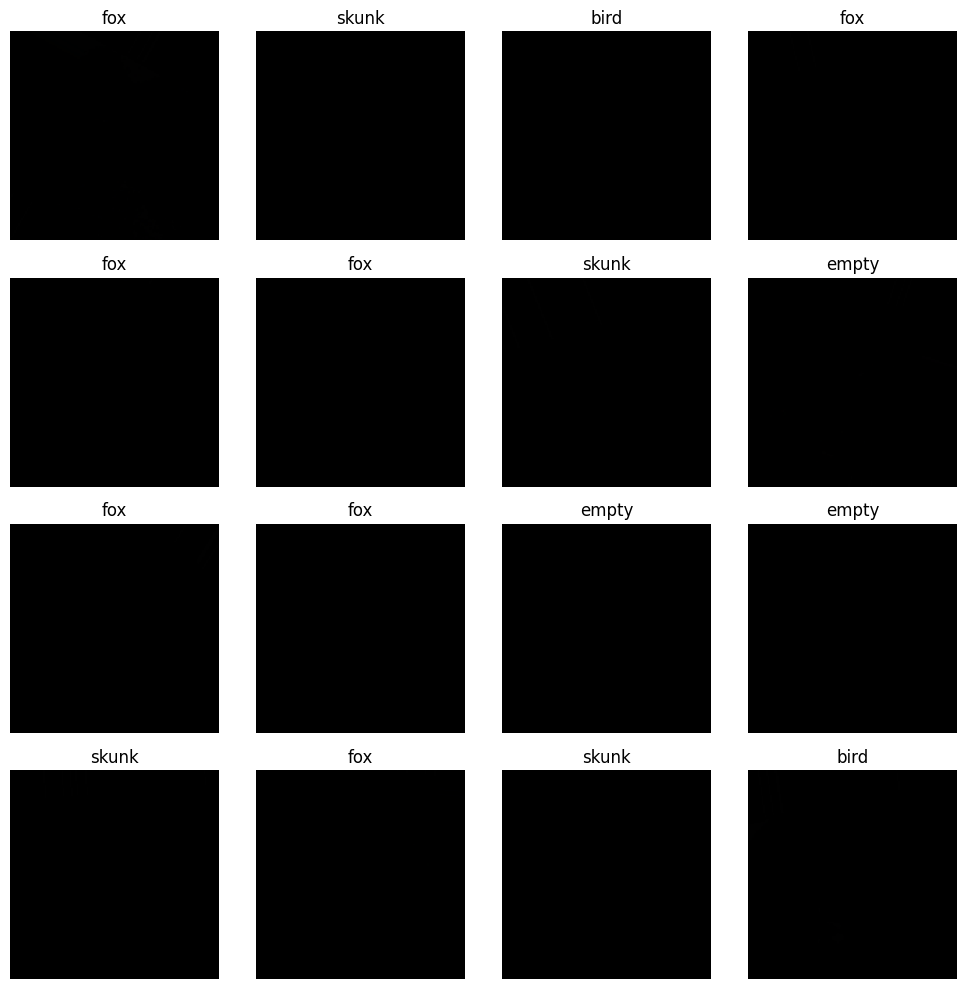

In [ ]:
#note: supposed to show images of them from my sci.zip dataset, however, not currently working.
#edit (08/27/24): got it to work. (code works, however on the html/ipynb file it does not show these results
#because I did not want to ruin my trained model by having to start over in running the notebook again.)

# Import the Matplotlib library for plotting and visualizing data

import matplotlib.pyplot as plt

# Define the class names corresponding to your categories (bird, empty, fox, skunk)
# These will be used to label the images in the plot.

class_names = ["bird", "empty", "fox", "skunk"]

# Set up the plotting area with a figure size of 10x10 inches and a resolution of 100 dots per inch (dpi)
# You can adjust these values to make the images larger or smaller.

plt.figure(figsize=(10, 10), dpi=100)  # Adjust figsize and dpi as needed.

# Fetch one batch of images and labels from the validation generator
# This gives us a set of images and their corresponding labels to visualize.

images, labels = next(validation_generator)

# Loop over the first 16 images in the batch (or however many images you want to display)

for i in range(16):
    # Create a subplot in a 4x4 grid (since 16 images) for the current image

    ax = plt.subplot(4, 4, i + 1)

    # Select the i-th image from the batch

    img = images[i]

    # Scale the image if needed
    # This part ensures that the image is properly displayed by converting it to an 8-bit format:
    # - If the image has pixel values in the range [0, 255], it is already in uint8 format.
    # - If the image has pixel values in the range [0, 1], we scale it up to [0, 255] and convert it to uint8.

    if img.max() > 1:  # Check if the image is in [0, 255]
        img = img.astype("uint8")
    else:  # Assume the image is in [0, 1] and scale it
        img = (img * 255).astype("uint8")

    # Display the image in the subplot

    plt.imshow(img)

    # Set the title of the subplot to the corresponding class name based on the label
    # I use the label (an integer) to index into class_names to get the correct name.

    plt.title(class_names[int(labels[i])])

    # Turn off the axis to make the plots look cleaner without the tick marks and labels

    plt.axis("off")

# Adjust the layout to prevent overlapping of subplots

plt.tight_layout()

# Display the entire plot with all the subplots

plt.show()


Finally, let's train the model using the features we extracted. We'll train on all of the images from the SCI dataset, for 30 epochs as well as validate them (using the unseen images from the validation folder in which the current trained model has not seen) during the training process to see how well the neural network is performing.

In [ ]:
#!pip install --upgrade tensorflow

# Calculate the number of steps per epoch for training and validation
# - steps_per_epoch: Total number of batches to process in each epoch during training.
#   This is calculated by dividing the total number of training images by the batch size.
# - validation_steps: Total number of batches to process in each epoch during validation.
#   This is calculated by dividing the total number of validation images by the batch size.

steps_per_epoch = len(train_generator.filenames) // batch_size
validation_steps = len(validation_generator.filenames) // batch_size

# Train the model using the training data
# - model.fit: This function trains the model with the training data and validates it using the validation data.
#   - train_generator: The training data generator feeds batches of training data (images and labels) into the model.
#   - steps_per_epoch: The number of batches to process in one epoch (complete pass through the training data).
#   - epochs=30: Number of times to go through the entire training dataset. More epochs allow the model to learn better,
# but too many can cause overfitting (where the model performs well on training data but poorly on new data).
#   - validation_data: The validation data generator that provides batches of images and labels for validation.
#   - validation_steps: The number of batches to process during validation at the end of each epoch.
#   - verbose=2: Controls the amount of information is shown during training. '2' provides a compact output showing progress of
# training and validation.

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Increase the epochs to allow more learning
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 - 114s - 1s/step - accuracy: 0.6405 - loss: 0.9773 - val_accuracy: 0.7741 - val_loss: 0.5942
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


81/81 - 5s - 60ms/step - accuracy: 0.8125 - loss: 0.5129 - val_accuracy: 0.6774 - val_loss: 0.8450
Epoch 3/30
81/81 - 85s - 1s/step - accuracy: 0.7614 - loss: 0.6295 - val_accuracy: 0.7227 - val_loss: 0.7005
Epoch 4/30
81/81 - 0s - 6ms/step - accuracy: 0.7500 - loss: 0.6789 - val_accuracy: 0.9032 - val_loss: 0.3399
Epoch 5/30
81/81 - 140s - 2s/step - accuracy: 0.8023 - loss: 0.5557 - val_accuracy: 0.8353 - val_loss: 0.4705
Epoch 6/30
81/81 - 0s - 6ms/step - accuracy: 0.8750 - loss: 0.2703 - val_accuracy: 0.8065 - val_loss: 0.5129
Epoch 7/30
81/81 - 84s - 1s/step - accuracy: 0.8008 - loss: 0.5328 - val_accuracy: 0.7161 - val_loss: 0.6208
Epoch 8/30
81/81 - 0s - 6ms/step - accuracy: 0.7500 - loss: 0.4583 - val_accuracy: 0.8065 - val_loss: 0.6950
Epoch 9/30
81/81 - 84s - 1s/step - accuracy: 0.8309 - loss: 0.4646 - val_accuracy: 0.8477 - val_loss: 0.4872
Epoch 10/30
81/81 - 0s - 5ms/step - accuracy: 0.8750 - loss: 0.4132 - val_accuracy: 0.6774 - val_loss: 0.6928
Epoch 11/30
81/81 - 78s - 9

You can see that we reach a validation accuracy of 90.32% very quickly.

Let's plot the training and validation loss and accuracy to show it conclusively:

* Note: Our goal in creating a trained model is to have our loss to be low as this shows a higher
predicted probability that the model is classifying our images correctly. However, not too low
since
this can lead to overfitting and we do not want that.

Text(0.5, 1.0, 'Training and Validation Loss')

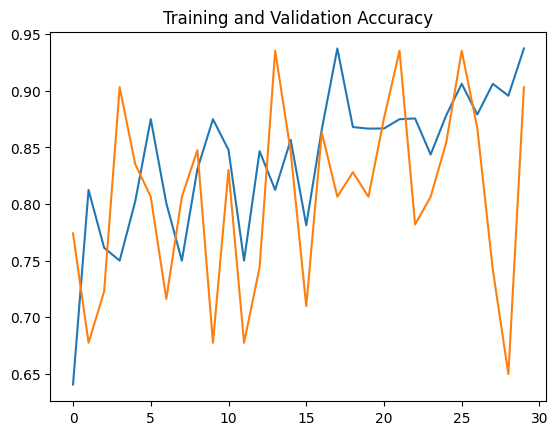

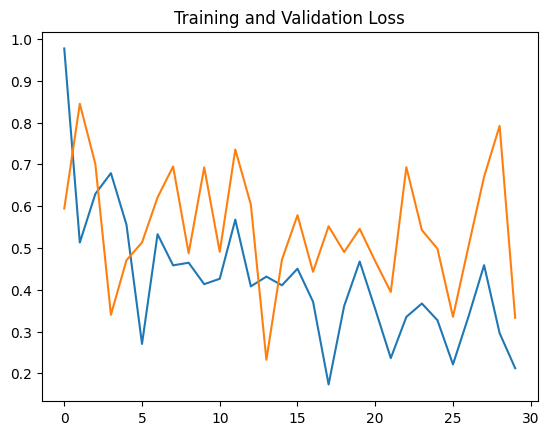

In [ ]:
%matplotlib inline

# Import the Matplotlib library for plotting graphs and images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch

loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs

epochs = range(len(acc))

# Plot training and validation accuracy per epoch

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')

plt.figure()

# Plot training and validation loss per epoch

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss')

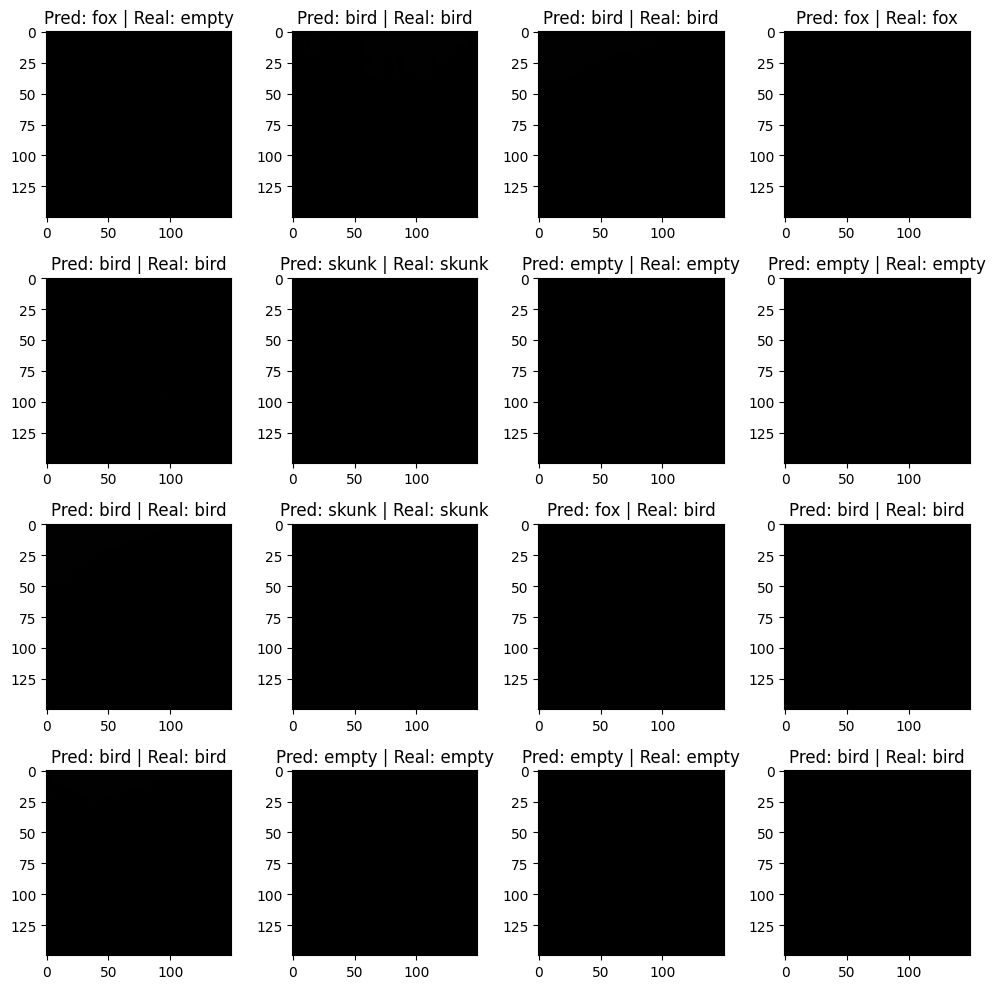

In [ ]:
#note: here I am attempting (still not fully functional) to give a visualization of what the model is doing in terms of
# classifying my images using the validation dataset AFTER I have finished the training process and therefore training my ideal
# image classification model which classifies (birds, empty (species frames), foxes, and skunks).

# Import the Matplotlib library for plotting graphs and images

import matplotlib.pyplot as plt
import numpy as np  # Import NumPy for numerical operations, used in finding the index of the maximum classification probability

# Define the class names corresponding to your categories (bird, empty, fox, skunk)
# These names will be used to label the images and show the predicted and actual classes.

class_names = ["bird", "empty", "fox", "skunk"]

# Fetch one batch of images and labels from the validation generator
# This retrieves a set of images and their corresponding labels for visualization.

images, labels = next(validation_generator)

# Pass the images through the model to get the classification predictions
# The model processes the images and returns a set of predictions, one for each image.

classifications = model(images)

# Set up the plotting area with a figure size of 10x10 inches and a resolution of 100 dots per inch (dpi)
# A higher DPI makes the images clearer.

plt.figure(figsize=(10, 10), dpi=100)

# Loop through the first 16 images in the batch to create subplots

for i in range(16):
    # Create a subplot in a 4x4 grid (since 16 images) for each image

    ax = plt.subplot(4, 4, i + 1)

    # Display the i-th image in the subplot
    # - images[i].astype("uint8"): Convert the image to 8-bit format for proper display.
    # - interpolation='bilinear': Ensures smoothness when displaying the image.

    plt.imshow(images[i].astype("uint8"), interpolation='bilinear')

    # Keep axis on to show the grid and axes for each image, providing additional information

    plt.axis('on')

    # Get the index of the class with the highest probability from the model's predictions

    index = np.argmax(classifications[i])

    # Set the title of the subplot to show both the predicted and actual class names
    # - class_names[index]: Predicted class based on the highest probability.
    # - class_names[int(labels[i])]: Actual class label for the image.

    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[int(labels[i])])

# Adjust the layout of the subplots to prevent overlapping of titles and images

plt.tight_layout()

# Display the entire grid of images with their predictions and actual labels

plt.show()


##Converting Model into Tensorflow Lite for Deployment


In [ ]:
import tensorflow as tf

# Assuming `model` is your trained Keras model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file

with open("/content/official_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite format!")


Saved artifact at '/tmp/tmpau74mk0s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139224459518272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954290864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954289984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954293152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954294208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954527648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954527296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954528176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954537680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139221954536096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13922195453732

In [ ]:
import os

# Check if the file exists in the Colab file system

file_path = '/content/official_model.tflite'
if os.path.exists(file_path):
    print("File saved successfully.")
else:
    print("File not found.")


File saved successfully.


In [ ]:
#note: downloading into my computer.

from google.colab import files
files.download('/content/official_model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Option 1: Verifying the Conversion
After converting the model, it’s a good practice to test it to ensure the conversion was successful and the model behaves as expected.

In [ ]:
import tensorflow as tf
import numpy as np

# Load the TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path="official_model.tflite")
interpreter.allocate_tensors()

# Get model input and output details

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Create an example input that matches the model's input shape

input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Set input tensor

interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference

interpreter.invoke()

# Get output tensor

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data)


Output: [[1.0058191e-04 9.9279177e-01 2.0083289e-03 5.0994051e-03]]


* The output [[1.0058191e-04, 9.9279177e-01, 2.0083289e-03, 5.0994051e-03]] indicates that the model predicts the image as "empty" with high confidence (99.28% probability).

* Another way to look at it: [Bird, Empty, Fox, Skunk].

* Note: This order was done when I created the dataset so it is not randomized.

#Option 2: Model Accuracy Verification
Note: Further testing to ensure that the model accurately working.

 To further verify, you can use real images from your dataset as input to the model and compare predictions against expected results. This involves preprocessing images similarly to how you did during training and feeding them into the TensorFlow Lite model.


In [ ]:
# Import necessary functions from TensorFlow Keras for image preprocessing

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Define the file path to the sample image that you want to test

img_path = '/content/sci/validation/fox/211.jpg'

# Load the image from the file path and resize it to the target size expected by the model (150x150 pixels)
# - target_size=(150, 150): Ensures the image is resized to the dimensions required by the model.

img = image.load_img(img_path, target_size=(150, 150))

# Convert the loaded image to a NumPy array
# - image.img_to_array: Converts the PIL Image instance to a NumPy array.
# - The array will have a shape of (150, 150, 3) for color images.

img_array = image.img_to_array(img)

# Add an extra dimension to the image array to match the input shape expected by the model
# - np.expand_dims: Adds an additional dimension to the array, resulting in a shape of (1, 150, 150, 3).
# - This is necessary because models in TensorFlow expect a batch dimension, even if it's a batch of one image.

img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image array to make it suitable for the model
# - preprocess_input: This function adjusts the image array (e.g., scaling pixel values) to match the format the model
# was trained on.
# - This step is crucial for ensuring that the input data is in the correct format for accurate predictions.

img_array = preprocess_input(img_array)

# Run inference using the TensorFlow Lite interpreter

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

# Retrieve the output from the interpreter
# - 'get_tensor': Retrieves the output tensor from the model.
# - output_data contains the model's prediction probabilities for each class.

output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the prediction probabilities
# - This shows the raw output from the model, which typically consists of probabilities for each class.
# - Higher probabilities indicate the model's confidence in a particular class for the input image.

print("Prediction probabilities:", output_data)


Prediction probabilities: [[1.5566873e-09 3.5068338e-06 9.9999499e-01 1.5273394e-06]]


Translation: The model is predicting with very high confidence that the image belongs to the 'fox' class, given the very high probability (0.99999499) for that class.

#Option 3: Model Success Verification

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Path to your test image

img_path = '/content/sci/validation/skunk/281.jpg'

# Load the image

img = Image.open(img_path)

# Resize the image to match model input

img = img.resize((150, 150))

# Convert image to numpy array and normalize pixel values

img_array = np.array(img) / 255.0

# Add batch dimension (1 sample)

img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

# Load TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path="official_model.tflite")
interpreter.allocate_tensors()

# Get input and output details

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set the input tensor

interpreter.set_tensor(input_details[0]['index'], img_array)

# Run inference

interpreter.invoke()

# Get the output tensor

output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the output

print("Output:", output_data)


Output: [[7.355834e-04 4.539452e-03 3.873580e-02 9.559892e-01]]


Translation: The highest probability value is 0.9559892, which corresponds to the fourth class (e.g., 'skunk'). This indicates that the model is most confident that the image belongs to the 'skunk' class.